In [5]:
#dataframe
import pandas as pd

#plots
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn import preprocessing

#model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#model assessment
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#tuning
from sklearn.model_selection import GridSearchCV

In [6]:
#Planning to use logistic regression, KNN, Random Forest and maybe Gradient boosting

In [7]:
waze_cleaned = pd.read_csv("../data/waze_processed.csv")
waze_cleaned.head()

,Android,iPhone,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,1,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19
1,0,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11
2,1,0,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8
3,0,1,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3
4,1,0,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18


<h3> Classes are inherently imbalanced

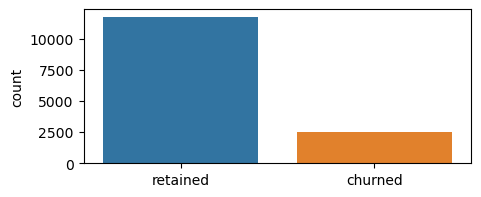

In [8]:
plt.figure(figsize = (5,2))
sns.countplot(x = waze_cleaned["label"])
plt.xlabel("");

In [9]:
retained_count = waze_cleaned['label'].value_counts().get("retained", 0)
churn_count = waze_cleaned['label'].value_counts().get("churned", 0)
churn_rate = churn_count/(churn_count+retained_count)
print("Total retained count:", retained_count)
print("Total churn count:", churn_count)
print("Churn rate", round(churn_rate, 2))

Total retained count: 11763
Total churn count: 2536
Churn rate 0.18


In [10]:
#The above cells show that the data is unbalanced. 
#Successful modelling may necessitate resampling to balance classes. 

<h3> Split data into testing and training datasets and standardize

In [11]:
#Split data into testing and training datasets
X = waze_cleaned.drop('label', axis = 1)
y = waze_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Standardize the magnitude of numeric features using a scaler
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

<h1> Logistic Regression

In [12]:
#Instantiate the model and set parameters
#I also tried the newton_cg solver, but went with liblinear and l2 (default) (Ridge) regularization. Similar accuracy results
clf_lr = LogisticRegression(solver = 'liblinear', max_iter = 500, random_state = 45)

In [13]:
#Fit the model using training set
clf_lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500, random_state=45, solver='liblinear')

In [14]:
#Predict y test and check accuracy on predicting test set
y_predict = clf_lr.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)
test_accuracy
#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf_lr.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)
train_accuracy
print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.8237762237762237
train accuracy: 0.8260337442084098


While checking for accuracy is only the first step, the well matched train/test accuracy (low variance, with only slightly higher accuracy for training set) is a good start with no obvious over/underfitting. I tried a confusion matrix and got array([[  34,  463],
       [  39, 2324]]), then different results, so went back and set a random state of 45 for consistent results

In [15]:
cm = confusion_matrix(y_test, y_predict, labels = clf_lr.classes_)
cm

array([[  47,  476],
       [  28, 2309]])

In [31]:

# Define the grid of values for C
param_grid = {'C': np.logspace(-4, 4, 20)}

# Implement Grid Search
grid_search = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print the best C value
best_C = grid_search.best_params_['C']
print(f"The best C value is: {best_C}")

The best C value is: 0.08858667904100823


In [34]:
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

# Assuming clf_lr is your logistic regression model, and X_train_scaled, y_train are prepared

# Define the grid of values for C
param_grid = {'C': np.logspace(-4, 4, 20)}

# Specify multiple scoring metrics
scoring = {'accuracy': make_scorer(accuracy_score, pos_label = 'churn'),
           'f1': make_scorer(f1_score, pos_label = 'churn'),
           'precision': make_scorer(precision_score, pos_label = 'churn'),
           'recall': make_scorer(recall_score, pos_label = 'churn')}

# Implement Grid Search with multiple scoring
grid_search = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=5, scoring=scoring, refit='accuracy', return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

# Extract the scores
results = grid_search.cv_results_
scores_df = pd.DataFrame.from_dict({
    'C': results['param_C'],
    'Accuracy': results['mean_test_accuracy'],
    'F1': results['mean_test_f1'],
    'Precision': results['mean_test_precision'],
    'Recall': results['mean_test_recall']
})

# Display the table
print(scores_df)

/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 175, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/inspect.

              C  Accuracy  F1  Precision  Recall
0        0.0001       NaN NaN        NaN     NaN
1      0.000264       NaN NaN        NaN     NaN
2      0.000695       NaN NaN        NaN     NaN
3      0.001833       NaN NaN        NaN     NaN
4      0.004833       NaN NaN        NaN     NaN
5      0.012743       NaN NaN        NaN     NaN
6      0.033598       NaN NaN        NaN     NaN
7      0.088587       NaN NaN        NaN     NaN
8      0.233572       NaN NaN        NaN     NaN
9      0.615848       NaN NaN        NaN     NaN
10     1.623777       NaN NaN        NaN     NaN
11     4.281332       NaN NaN        NaN     NaN
12    11.288379       NaN NaN        NaN     NaN
13    29.763514       NaN NaN        NaN     NaN
14    78.475997       NaN NaN        NaN     NaN
15   206.913808       NaN NaN        NaN     NaN
16   545.559478       NaN NaN        NaN     NaN
17  1438.449888       NaN NaN        NaN     NaN
18  3792.690191       NaN NaN        NaN     NaN
19      10000.0     

/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 175, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/inspect.

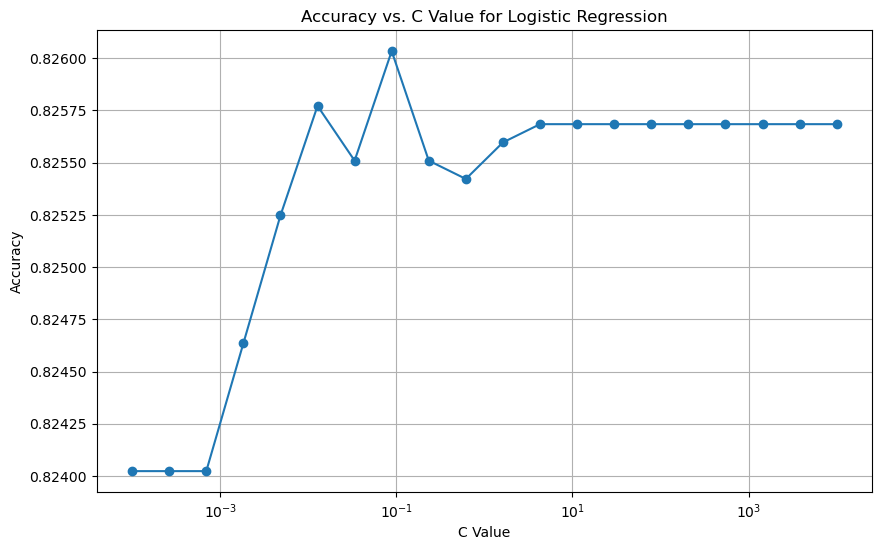

Looks like the default C (1.00) is probably the best, but C= 10 and C=100 had the same accuracy score. Let's see if we can get a better confusion matrix. 

In [17]:
#instantiate new model with C = 10
clf_lr = LogisticRegression( max_iter = 500, C = 10, random_state = 45)
cm = confusion_matrix(y_test, y_predict)
cm

array([[  47,  476],
       [  28, 2309]])

In [18]:
#instantiate new model with C = 100
clf_lr = LogisticRegression( max_iter = 500, C = 10, random_state = 45)
cm = confusion_matrix(y_test, y_predict)
cm

array([[  47,  476],
       [  28, 2309]])

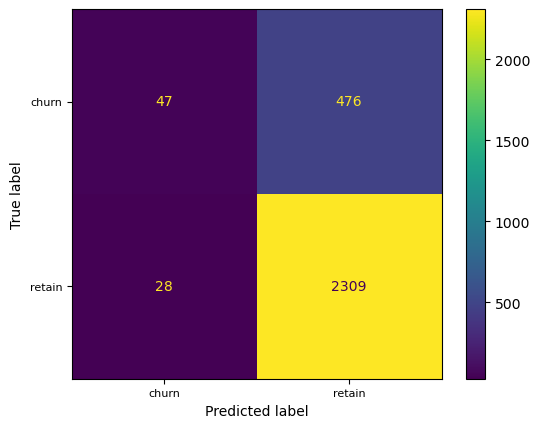

In [19]:
#Looks like they all produce the same results. Here is the display
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm 
                                    , display_labels = ['churn', 'retain'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

ax.set_xticklabels(labels = ['churn', 'retain'], fontsize = 8)
ax.set_yticklabels(labels = ['churn', 'retain'], fontsize = 8)
display_cm.plot(ax = ax);

In [20]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

     churned       0.63      0.09      0.16       523
    retained       0.83      0.99      0.90      2337

    accuracy                           0.82      2860
   macro avg       0.73      0.54      0.53      2860
weighted avg       0.79      0.82      0.77      2860



<h1> K Nearest Neighbors 

In [21]:

Ks = range(1,10)

table = pd.DataFrame(columns = ['K','Accuracy'])
table['K'] = Ks

j = 0
for K in Ks:
    
    # Apply Knn model to training data
    clf_knn = KNeighborsClassifier(n_neighbors = K)
    clf_knn.fit(X_train_scaled,y_train)
    
    # Predict using model
    y_pred_knn = clf_knn.predict(X_test_scaled)
    
    # Saving accuracy score in table
    table.iloc[j,1] = accuracy_score(y_test,y_pred_knn)
    j += 1
    
table  

,K,Accuracy
0,1,0.753497
1,2,0.674825
2,3,0.796503
3,4,0.768881
4,5,0.804196
5,6,0.783566
6,7,0.808042
7,8,0.798252
8,9,0.810839


In [22]:
#Use GridSearchCV to confirm best K value

# Define the parameter grid: values of K to test
param_grid = {'n_neighbors': range(1, 10)}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Find the best parameters and use them to calculate accuracy on the test set
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)

# Output the best K value and corresponding accuracy
best_k = grid_search.best_params_['n_neighbors']
print('Best K value:', best_k) 
print('Best Accuracy:', best_accuracy)

Best K value: 9
Best Accuracy: 0.8108391608391609


In [23]:
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train_scaled,y_train)

y_pred = knn.predict(X_test_scaled)

In [24]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

     churned       0.44      0.13      0.20       523
    retained       0.83      0.96      0.89      2337

    accuracy                           0.81      2860
   macro avg       0.64      0.55      0.55      2860
weighted avg       0.76      0.81      0.77      2860



<h2> Random Forest

In [25]:
clf_rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)
model_res = clf_rf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print('Random Forest Accuracy = ', ac)
print('Random Forest f1-score =' , f1)

Random Forest Accuracy =  0.8132867132867133
Random Forest f1-score = 0.7674442686475628


In [26]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[  67,  456],
       [  78, 2259]])

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     churned       0.46      0.13      0.20       523
    retained       0.83      0.97      0.89      2337

    accuracy                           0.81      2860
   macro avg       0.65      0.55      0.55      2860
weighted avg       0.76      0.81      0.77      2860



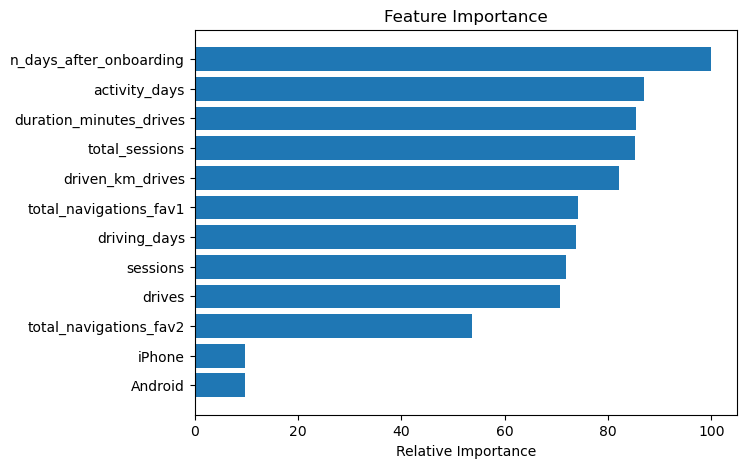

In [28]:
feature_importance = clf_rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show();